In [1]:
from pyEDM import *
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import os
import geopandas as gpd
from shapely.geometry import Polygon
import rasterio
import xarray as xr
from mpl_toolkits.axes_grid1 import make_axes_locatable
import fiona
import rasterio.mask
from descartes import PolygonPatch
from rasterio.plot import show
from tqdm import tqdm
import datetime
import random
from sklearn.preprocessing import StandardScaler
import scipy.stats
from datetime import datetime

In [12]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
precip_anom_dir = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/CHIRPS/Anomaly/'
temp_anom_dir = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/LST/Anomaly/'
# ndvi_anom_dir = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/eMODIS_NDVI/Anomaly/'
ndvi_anom_dir = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/eMODIS_NDVI/Anomaly/'

In [2]:
precip_anom2_dir = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/CHIRPS/Anomaly2/'
temp_anom2_dir = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/LST/Anomaly2/'
# ndvi_anom_dir = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/eMODIS_NDVI/Anomaly/'
ndvi_anom2_dir = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/eMODIS_NDVI/Anomaly2/'

In [14]:
precip_anom3_dir = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/CHIRPS/Anomaly3/'
temp_anom3_dir = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/LST/Anomaly3/'
ndvi_anom3_dir = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/eMODIS_NDVI/Anomaly3/'

In [3]:
#prediction_tables = '/home/rgreen/tana-crunch/rgreen/crunch/DroughtEDM/Data/predictions_tables/'
prediction_tables = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/predictions_tables/'

In [4]:
def generate_dekads(start, end):
    '''
    Generates list of timestamps of dekads between two dates
    
    Parameters
    ----------
    start : pd.datetime object
        Start date of list
    end : pd.datetime object
        end date of list
    '''
    
    dtrange = pd.date_range(start, end)
    days = list(range(len(dtrange))) #length of dtrange
    daysDF = pd.DataFrame({'Days': days}, index=dtrange)
    d = daysDF.index.day - np.clip((daysDF.index.day-1) // 10, 0, 2)*10 - 1 
    dekaddates = daysDF.index.values - np.array(d, dtype="timedelta64[D]")
    dekads = daysDF.groupby(dekaddates).mean()
    dekads = dekads.index
    
    return dekads

In [5]:
start = pd.datetime(2002,7,1)
end = pd.datetime(2019,4,30)

dekads = generate_dekads(start, end)

In [6]:
def pixelwise_ts_table(in_dir, keyword):
    
    '''
    This function searches through the file directory and creates a dataframe of pixel values over time from rasters
    based on a given keyword describing the environmental variable of interest to generate a raster time series stack 
    
   In the output dataframe, columns are each pixel extracted from the raster (read squentially into a list)
   and rows are the same pixel over time (dekads going down)
    
    Args:
    - in_dir: path to the input directory
    -keyword: string that is unique to the environmental variable
        options: ['precip', 'temp', 'ndvi']
    '''
    
    
    files=np.array(sorted(os.listdir(in_dir)))
    tifs = pd.Series(files).str.contains(keyword)
    files = files[tifs]
        
    pixelwise_TS = []
    
    for filename in tqdm(files): 
        
        
            open_file = xr.open_rasterio(in_dir+filename).sel(band=1)
            array = open_file.values
            
            pixel_list = array.ravel().tolist()
            
            pixelwise_TS.append(pixel_list)

    return pd.DataFrame(pixelwise_TS)

    

In [8]:
precip_table_anom = pixelwise_ts_table(precip_anom_dir, 'precip')
temp_table_anom = pixelwise_ts_table(temp_anom_dir, 'temp')
ndvi_table_anom = pixelwise_ts_table(ndvi_anom_dir, 'ndvi')

100%|██████████| 606/606 [00:19<00:00, 30.53it/s]


In [8]:
precip_table_anom2 = pixelwise_ts_table(precip_anom2_dir, 'precip')
temp_table_anom2 = pixelwise_ts_table(temp_anom2_dir, 'temp')
ndvi_table_anom2 = pixelwise_ts_table(ndvi_anom2_dir, 'ndvi')

100%|██████████| 606/606 [00:19<00:00, 31.18it/s]


In [ ]:
ndvi_table_anom2

In [22]:
low_high_ts_df_anom2 = pd.DataFrame(list(zip(ndvi_table_anom2[28965], precip_table_anom2[28965], temp_table_anom2[28965], ndvi_table_anom2[28965], precip_table_anom2[28965], temp_table_anom2[28965])),
                             columns = ['NDVI_low_skill', 'Precip_low_skill', 'Temp_low_skill', 'NDVI_high_skill', 'Precip_high_skill', 'Temp_high_skill'])


In [23]:
low_high_ts_df_anom2

,NDVI_low_skill,Precip_low_skill,Temp_low_skill,NDVI_high_skill,Precip_high_skill,Temp_high_skill
0,-0.013461,-0.927125,2.494026,-0.013461,-0.927125,2.494026
1,-0.016173,-1.585304,5.813889,-0.016173,-1.585304,5.813889
2,-0.018384,0.380949,2.236801,-0.018384,0.380949,2.236801
3,-0.016101,-3.727844,0.607304,-0.016101,-3.727844,0.607304
4,-0.016101,-3.471904,0.607304,-0.016101,-3.471904,0.607304
...,...,...,...,...,...,...
601,-0.003383,-2.196862,-2.995525,-0.003383,-2.196862,-2.995525
602,-0.015850,-2.267092,-3.514112,-0.015850,-2.267092,-3.514112
603,-0.022378,-7.740677,1.389336,-0.022378,-7.740677,1.389336
604,-0.019531,-7.863825,0.335155,-0.019531,-7.863825,0.335155


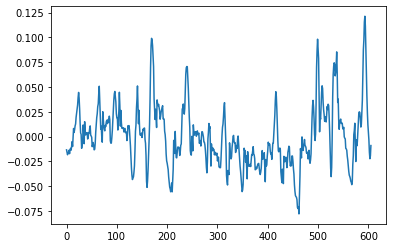

In [25]:
plt.plot(low_high_ts_df_anom2.index, low_high_ts_df_anom2.NDVI_low_skill)

In [24]:
low_high_ts_df_anom2.to_csv('/home/rgreen/DroughtEDM/low_high_ts_df_clim_anom.csv')

In [20]:
precip_table_anom3 = pixelwise_ts_table(precip_anom3_dir, 'precip')
temp_table_anom3 = pixelwise_ts_table(temp_anom3_dir, 'temp')
ndvi_table_anom3 = pixelwise_ts_table(ndvi_anom3_dir, 'ndvi')

100%|██████████| 606/606 [00:19<00:00, 31.68it/s]


In [9]:
precip_table_anom.label = 'precip'
precip_table_anom.rs_rows = 674
precip_table_anom.rs_cols = 583
precip_table_anom.n_samples = 606
ndvi_table_anom.label = 'ndvi'
ndvi_table_anom.rs_rows = 674
ndvi_table_anom.rs_cols = 583
ndvi_table_anom.n_samples = 606
temp_table_anom.label = 'temp'
temp_table_anom.rs_rows = 674
temp_table_anom.rs_cols = 583
temp_table_anom.n_samples = 606

table_list_anom = [precip_table_anom, ndvi_table_anom, temp_table_anom]

In [23]:
precip_table_anom3.label = 'precip'
precip_table_anom3.rs_rows = 674
precip_table_anom3.rs_cols = 583
precip_table_anom3.n_samples = 606
ndvi_table_anom3.label = 'ndvi'
ndvi_table_anom3.rs_rows = 674
ndvi_table_anom3.rs_cols = 583
ndvi_table_anom3.n_samples = 606
temp_table_anom3.label = 'temp'
temp_table_anom3.rs_rows = 674
temp_table_anom3.rs_cols = 583
temp_table_anom3.n_samples = 606

table_list_anom3 = [precip_table_anom3, ndvi_table_anom3, temp_table_anom3]

In [10]:
def multi_pixelwise_simplex(tables, target_label, train, test, ed, pi): #year month_list, 
    
    '''
    This function computes the simplex prediction skill for a given embedding dimensions, prediction interval, land cover and environmental variable
    across pixels given multiple tables of different variables of pixel values across time for a region from the function pixelwise_ts_table 

    The result is an np.array of simplex error values reshaped back into the shape of the original raster image
    
    Args:
    - table: list of input tables, where every table has columns with the time series of each pixel in a raster
    - target_label: text label for the table to be used as the target (e.g. 'ndvi')
    - train: portion of data library used to train (string of range with space between values)
    - test: portion of data libary used to test (string of range with space between values) 
    - ed: embedding dimension
    - pi: prediction interval (Tp) 
    - rs_rows: number of rows to reshape list into original raster size
    - rs_cols: number of columns to reshape list into original raster size
   
    '''

    table_dict = {'Time': dekads }
    
#     if simplex_out is None:
#         simplex_out = pd.DataFrame()
    simplex_out= []
    labels = ' '.join([table.label for table in tables]) # Assumes that all tables have labels

    # Generate future dekads
    dekads_fut = generate_dekads(dekads[-1],pd.datetime(2020,4,30))
    
   
    
    # Iterate through columns (pixels)
    for col_idx in tqdm(range(len(tables[0].columns))):
        
        now=datetime.now()
        # PIXEL DATAFRAME
        # Generate dataframe for pixel where columns correspond to variables and rows to timestamp (image)
        [table_dict.update({table.label: table.iloc[:,col_idx]}) for i, table in enumerate(tables)]
        #interim_df = pd.DataFrame(table_dict, index = dekads)
        interim_df = pd.DataFrame(table_dict)

        interim_df.set_index('Time',inplace=True, drop=False)
        
        
                # If column has lots of nans (water), append nan
        if max([len(interim_df[interim_df[col_idx].isnull()]) for col_idx in interim_df.columns]) > 20:
            nans = [np.nan]*(len(interim_df)-ed+pi+1)
            #simplex_out[col_idx] = [np.nan]*(len(interim_df)-ed+pi+1)
            simplex_out.append(nans)
        else:

            # Check whether column has a few nans
            if interim_df.temp.isnull().values.any():
                # If so, iterate through nan rows and replace with monthly mean
                for t in interim_df[interim_df.temp.isnull()].index:
                    interim_df.temp.loc[t] = interim_df.temp[interim_df.index.month == t.month].mean()
                    #print(interim_df)
            if interim_df.ndvi.isnull().values.any():
            # If so, iterate through nan rows and replace with monthly mean
                for t in interim_df[interim_df.ndvi.isnull()].index:
                    interim_df.ndvi.loc[t] = interim_df.ndvi[interim_df.index.month == t.month].mean()
            if interim_df.precip.isnull().values.any():
            # If so, iterate through nan rows and replace with monthly mean
                for t in interim_df[interim_df.precip.isnull()].index:
                    interim_df.precip.loc[t] = interim_df.precip[interim_df.index.month == t.month].mean()
            #print(interim_df)
            
            # Run simplex
            
            simplex_result = Simplex(dataFrame = interim_df,
                                     lib = train,
                                     pred = test,
                                     E = ed, Tp = pi,
                                     columns = labels, target = target_label, showPlot = False)

            
            
            # Add datetime index + fix dekad values for future values
            simplex_result.Time = pd.to_datetime(simplex_result.Time)
            simplex_result.set_index(simplex_result.Time, inplace=True)
            
            
            # Fix datetime index for future dekads
            simplex_result[-pi:].Time = dekads_fut[1:pi+1]
            
            #simplex_result.dropna()
            #simplex_out[col_idx] = simplex_result.Predictions
            #print(simplex_result.Predictions.tolist())
            
            predictions = simplex_result.Predictions.tolist()
            simplex_out.append(predictions)
            
            #print(simplex_out[i])
            delta=datetime.now()-now
            #print(delta)
    return pd.DataFrame(simplex_out).T
    


In [ ]:
ndvi_ea_simplex_ed6_pi1 = multi_pixelwise_simplex(table_list_anom, 'ndvi', train = '1 606', test = '1 606',ed = 6, pi = 1)

In [ ]:
ndvi_ea_simplex_ed6_pi2 = multi_pixelwise_simplex(table_list_anom, 'ndvi', train = '1 606', test = '1 606',ed = 6, pi = 2)

  2%|▏         | 9708/392942 [07:34<4:55:50, 21.59it/s]

In [13]:
x

NameError: name 'x' is not defined

In [22]:
ndvi_ea_simplex_ed6_pi3 = multi_pixelwise_simplex(table_list_anom, 'ndvi', train = '1 606', test = '1 606',ed = 6, pi = 3)

100%|██████████| 392942/392942 [4:39:29<00:00, 23.43it/s]   


In [24]:
ndvi_ea_simplex_ed6_pi4 = multi_pixelwise_simplex(table_list_anom, 'ndvi', train = '1 606', test = '1 606',ed = 6, pi = 4)

100%|██████████| 392942/392942 [4:40:31<00:00, 23.35it/s]   


In [ ]:
ndvi_ea_simplex_ed6_pi5 = multi_pixelwise_simplex(table_list_anom, 'ndvi', train = '1 606', test = '1 606',ed = 6, pi = 5)

 18%|█▊        | 69965/392942 [57:48<4:48:55, 18.63it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 96%|█████████▋| 378938/392942 [4:42:39<02:12, 105.97it/s]  

In [29]:
ndvi_ea_simplex_ed6_pi6 = multi_pixelwise_simplex(table_list_anom, 'ndvi', train = '1 606', test = '1 606',ed = 6, pi = 6)

  5%|▍         | 19046/392942 [16:16<4:56:46, 21.00it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 70%|███████   | 275447/392942 [3:43:18<1:49:22, 17.90it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 82%|████████▏ | 320363/392942 [4:09:32<1:04:40, 18.70it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variabl

In [ ]:
ndvi_ea_simplex_ed6_pi7 = multi_pixelwise_simplex(table_list_anom, 'ndvi', train = '1 606', test = '1 606',ed = 6, pi = 7)

 10%|█         | 39833/392942 [32:46<5:01:09, 19.54it/s]

In [ ]:
ndvi_ea_simplex_ed6_pi8 = multi_pixelwise_simplex(table_list_anom, 'ndvi', train = '1 606', test = '1 606',ed = 6, pi = 8)

In [ ]:
ndvi_ea_simplex_ed6_pi9 = multi_pixelwise_simplex(table_list_anom, 'ndvi', train = '1 606', test = '1 606',ed = 6, pi = 9)

 35%|███▌      | 137850/392942 [1:46:00<3:51:47, 18.34it/s]

In [ ]:
ndvi_ea_simplex_ed6_pi10 = multi_pixelwise_simplex(table_list_anom, 'ndvi', train = '1 606', test = '1 606',ed = 6, pi = 10)

  8%|▊         | 29600/392942 [24:31<5:00:51, 20.13it/s]

In [ ]:
ndvi_ea_simplex_ed6_pi11 = multi_pixelwise_simplex(table_list_anom, 'ndvi', train = '1 606', test = '1 606',ed = 6, pi = 11)

 10%|▉         | 38892/392942 [31:09<3:37:22, 27.15it/s]

In [ ]:
ndvi_ea_simplex_ed6_pi12 = multi_pixelwise_simplex(table_list_anom, 'ndvi', train = '1 606', test = '1 606',ed = 6, pi = 12)

In [ ]:
ndvi_ea_simplex_ed6_pi18_clim_anom = multi_pixelwise_simplex(table_list_anom2, 'ndvi', train = '1 606', test = '1 606',ed = 6, pi = 18)

In [ ]:
ndvi_ea_simplex_ed6_pi18_anom3 = multi_pixelwise_simplex(table_list_anom3, 'ndvi', train = '1 606', test = '1 606',ed = 6, pi = 18)

 16%|█▌        | 61496/392942 [54:21<5:18:48, 17.33it/s] 

In [ ]:
ndvi_ea_simplex_ed6_pi18_anom = multi_pixelwise_simplex(table_list_anom, 'ndvi', train = '1 606', test = '1 606',ed = 6, pi = 18)

  1%|▏         | 5697/392942 [05:11<6:24:47, 16.77it/s]

In [45]:
x

NameError: name 'x' is not defined

In [ ]:
ndvi_ea_simplex_ed6_pi13 = multi_pixelwise_simplex(table_list_anom, 'ndvi', train = '1 606', test = '1 606',ed = 6, pi = 13)

  6%|▋         | 25173/392942 [20:51<5:29:29, 18.60it/s] 

In [ ]:
ndvi_ea_simplex_ed6_pi14 = multi_pixelwise_simplex(table_list_anom, 'ndvi', train = '1 606', test = '1 606',ed = 6, pi = 14)

In [ ]:
ndvi_ea_simplex_ed6_pi15 = multi_pixelwise_simplex(table_list_anom, 'ndvi', train = '1 606', test = '1 606',ed = 6, pi = 15)

 90%|████████▉ | 352496/392942 [4:27:20<28:30, 23.64it/s]   

In [ ]:
ndvi_ea_simplex_ed6_pi16 = multi_pixelwise_simplex(table_list_anom, 'ndvi', train = '1 606', test = '1 606',ed = 6, pi = 16)

In [ ]:
ndvi_ea_simplex_ed6_pi17 = multi_pixelwise_simplex(table_list_anom, 'ndvi', train = '1 606', test = '1 606',ed = 6, pi = 17)

In [21]:
x

NameError: name 'x' is not defined

In [ ]:
ndvi_ea_simplex_ed6_pi1.to_csv(prediction_tables + 'ndvi_ea_simplex_ed6_pi1.csv')

In [15]:
ndvi_ea_simplex_ed6_pi2.to_csv(prediction_tables + 'ndvi_ea_simplex_ed6_pi2.csv')

In [23]:
ndvi_ea_simplex_ed6_pi3.to_csv(prediction_tables + 'ndvi_ea_simplex_ed6_pi3.csv')

In [25]:
ndvi_ea_simplex_ed6_pi4.to_csv(prediction_tables + 'ndvi_ea_simplex_ed6_pi4.csv')

In [28]:
ndvi_ea_simplex_ed6_pi5.to_csv(prediction_tables + 'ndvi_ea_simplex_ed6_pi5.csv')

In [31]:
ndvi_ea_simplex_ed6_pi6.to_csv(prediction_tables + 'ndvi_ea_simplex_ed6_pi6.csv')

In [41]:
ndvi_ea_simplex_ed6_pi7.to_csv(prediction_tables + 'ndvi_ea_simplex_ed6_pi7.csv')

In [42]:
ndvi_ea_simplex_ed6_pi8.to_csv(prediction_tables + 'ndvi_ea_simplex_ed6_pi8.csv')

In [45]:
ndvi_ea_simplex_ed6_pi9.to_csv(prediction_tables + 'ndvi_ea_simplex_ed6_pi9.csv')

In [48]:
ndvi_ea_simplex_ed6_pi10.to_csv(prediction_tables + 'ndvi_ea_simplex_ed6_pi10.csv')

In [51]:
ndvi_ea_simplex_ed6_pi11.to_csv(prediction_tables + 'ndvi_ea_simplex_ed6_pi11.csv')

In [52]:
ndvi_ea_simplex_ed6_pi12.to_csv(prediction_tables + 'ndvi_ea_simplex_ed6_pi12.csv')

In [13]:
ndvi_ea_simplex_ed6_pi18.to_csv(prediction_tables + "ndvi_ea_simplex_ed6_pi18_clim_anom.csv")

In [28]:
ndvi_ea_simplex_ed6_pi18_anom3.to_csv(prediction_tables + 'ndvi_ea_simplex_ed6_pi18_anom3.csv')

In [46]:
ndvi_ea_simplex_ed6_pi18_anom.to_csv(prediction_tables + 'ndvi_ea_simplex_ed6_pi18_anom.csv')

In [1]:
ndvi_ea_simplex_ed6_pi18_anom

NameError: name 'ndvi_ea_simplex_ed6_pi18_anom' is not defined

In [16]:
ndvi_ea_simplex_ed6_pi13.to_csv(prediction_tables + 'ndvi_ea_simplex_ed6_pi13.csv')

In [17]:
ndvi_ea_simplex_ed6_pi14.to_csv(prediction_tables + 'ndvi_ea_simplex_ed6_pi14.csv')

In [22]:
ndvi_ea_simplex_ed6_pi15.to_csv(prediction_tables + 'ndvi_ea_simplex_ed6_pi15.csv')

In [23]:
ndvi_ea_simplex_ed6_pi16.to_csv(prediction_tables + 'ndvi_ea_simplex_ed6_pi16.csv')

In [24]:
ndvi_ea_simplex_ed6_pi17.to_csv(prediction_tables + 'ndvi_ea_simplex_ed6_pi17.csv')